In [10]:
import torch
import matplotlib.pyplot as plt

from src.models.ulosd_layers import FeatureMapsToKeyPoints, KeyPointsToFeatureMaps

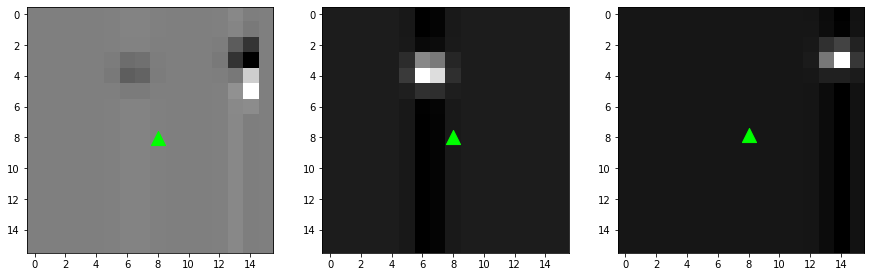

In [11]:
K = 3
W = 16
H = 16


fmap2kpt = FeatureMapsToKeyPoints('cpu')
kpt2gmap = KeyPointsToFeatureMaps(1.5, W, 'cpu')

fmap = torch.rand((1, K, H, W))
kpts = fmap2kpt(fmap) + ((torch.rand(1, K, 3) - 0.5)*2.0)
fmap = kpt2gmap(kpts)

# Distortions
fmap[0, 0, ...] -= ((fmap[0, 1, ...] * 0.25) + (fmap[0, 2, ...] * 0.25))
fmap[0, 0, :, W-1] = 0.5
fmap = torch.softmax(fmap, dim=-2)

kpts = fmap2kpt(fmap)

fig, ax = plt.subplots(1, K, figsize=(15, 5))
for k in range(K):
    ax[k].imshow(fmap[0, k, ...], cmap='gray')
    w = ((-kpts[0, k, 1] + 1) / 2) * W
    h = ((kpts[0, k, 0] + 1) / 2) * H
    ax[k].scatter(w, h, s=200, c='lime', marker='^')
plt.show()

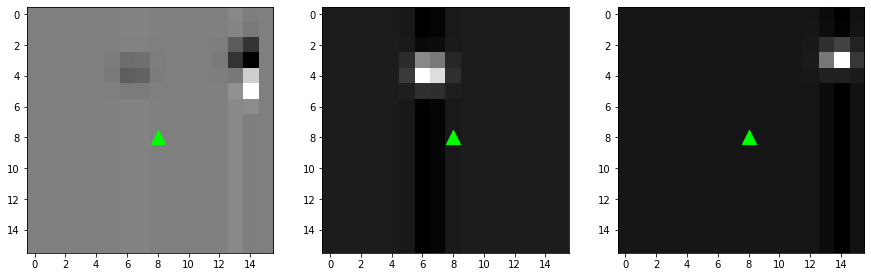

In [12]:
from src.models.transporter_keypointer import TransporterKeypointer

config = {
    'model': {
        'hidden_dim': 32,
        'num_img_channels': 3,
        'activation': 'LeakyReLU',
        'skip_connections': False,
        'num_keypoints': 3,
        'gaussian_map_std': 1.5
    },
    'device': 'cpu'
}

kpter = TransporterKeypointer(config)

transporter_kpts, gmaps = kpter.feature_maps_to_keypoints(fmap)

fig, ax = plt.subplots(1, K, figsize=(15, 5))
for k in range(K):
    ax[k].imshow(fmap[0, k, ...], cmap='gray')
    w = ((-transporter_kpts[0, k, 1] + 1) / 2) * W
    h = ((transporter_kpts[0, k, 0] + 1) / 2) * H
    ax[k].scatter(w, h, s=200, c='lime', marker='^')
plt.show()

In [13]:
print(fmap.shape)

torch.Size([1, 3, 16, 16])


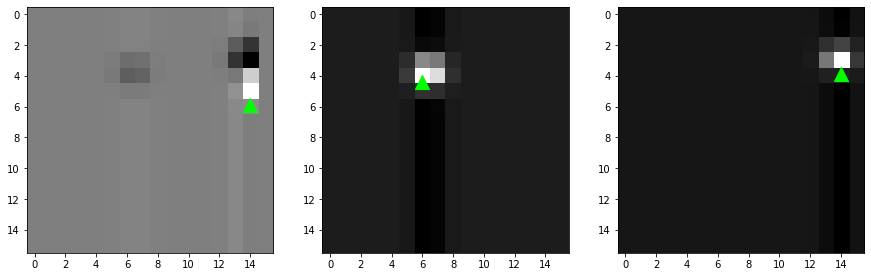

In [14]:
fig, ax = plt.subplots(1, K, figsize=(15, 5))
for k in range(K):
    ax[k].imshow(fmap[0, k, ...], cmap='gray')
    maxloc = torch.argmax(fmap[0, k, ...])
    h = maxloc/H
    w = maxloc%W
    ax[k].scatter(w, h, s=200, c='lime', marker='^')
plt.show()